# **EPS AI**

**This to build and train an AI model for Major Tuning EPS**

# **Section 1: Understand the data**



1. What input do we have？
    - 12 Tuning Parameters.
    - Product Type.
    - all 14 Reactors ID.
2. What output do we have?
    - Target / Result Resistivity.
    - Target / Result Thickness.
    - Pass / Fail Result for every tune.

We need a model to recoomend tuning parameters before tuning.
This is a regression & optimization problem. (Use Random Forest)



|S/N: | Shortcuts | Description |
| --- | --- | --- |
|1.| Ctrl + Enter | Run Code Cell |
|2.| Ctrl + a | Select everything |
|3.| Ctrl + c | Copy |
|4.| Ctrl + v | paste |
|5.| Ctrl + / | Comment/Uncomment |
|6.| Ctrl + [ | Dedent (Moving your code 2 or 4 spaces **BACK**, depending on your settings) |
|7.| Ctrl + ] | Indent (Moving your code 2 or 4 spaces **FORWARD**, depending on your settings)|

# **Section 2: Understand the data**


Given a product and reactor, predict what set of 12 tuning parameters will most likely result in acceptable resistivity & thickness.


# **Section 3: Data Organization**


Prepare for modeling
1. Encode Product Type, Reactor ID, Hardware Version using label encoding.
2. Normalize / Standardize the tuning parameters and target if needed.
3. Check for missing dat.

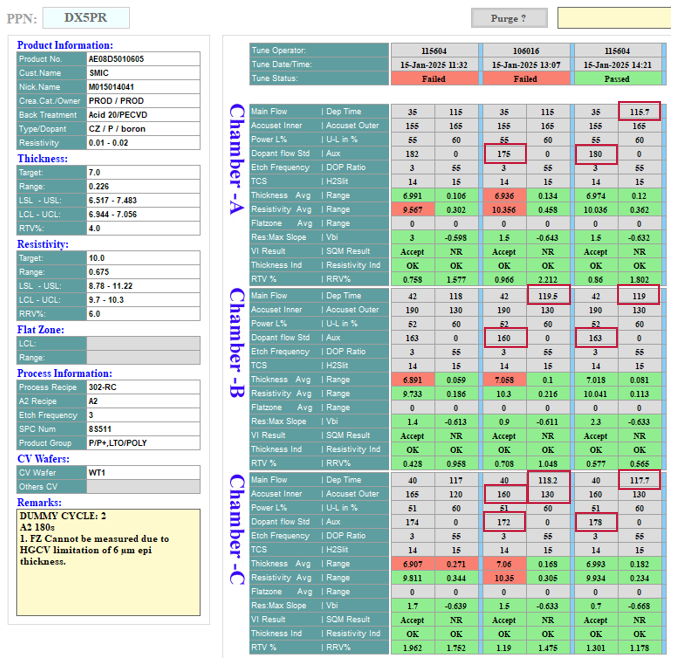

Thickness AVG -> Adjust DEP Time

Resistivity AVG -> Adjust Dop Flow

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

In [21]:
epiData = pd.read_csv('/content/drive/MyDrive/EPI AI/DataForTrain.csv')
epiData

,REACTOR_ID,TUNE_ATTEMPT,CHAMBER_ID,CHAMBER_ENABLE,PRODUCT,SPC_NUM,EPI_RECIPE,MAIN_FLOW,DEP_TIME,ACCUSET_INNER,...,ETCH_FREQUENCY,TCS,H2SLIT,R_THICK_AVG,R_RESIST_AVG,TUNE_THICK_LCL,TUNE_THICK_UCL,TUNE_RESIST_LCL,TUNE_RESIST_UCL,TUNE_RESULT
0,501664,1,A,Y,AE08D5340201,8S805,317-HI,38.0,66.6,163.0,...,6.0,14.0,15.0,4.152333,19.55682,3.968,4.032,18.915,20.085,Failed
1,501664,1,B,Y,AE08D5340201,8S805,317-HI,35.0,65.6,130.0,...,6.0,14.0,15.0,4.168556,20.29496,3.968,4.032,18.915,20.085,Failed
2,501664,1,C,Y,AE08D5340201,8S805,317-HI,35.0,63.0,140.0,...,6.0,14.0,15.0,4.043222,21.10730,3.968,4.032,18.915,20.085,Failed
3,501664,1,A,N,AE08D3480302,8S806,317-HI,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.952,6.048,18.915,20.085,Passed
4,501664,1,B,Y,AE08D3480302,8S806,317-HI,35.0,94.5,130.0,...,4.0,14.0,15.0,5.975222,19.02642,5.952,6.048,18.915,20.085,Passed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,501664,1,B,Y,AE08E1320201,8S806,317-HI,35.0,103.6,120.0,...,4.0,14.0,15.0,6.038444,19.67752,5.952,6.048,18.915,20.085,Failed
1934,501664,1,C,Y,AE08E1320201,8S806,317-HI,28.0,99.1,140.0,...,4.0,14.0,15.0,6.020667,20.34528,5.952,6.048,18.915,20.085,Failed
1935,501664,1,A,Y,AE08E1320201,8S806,317-HI,38.0,100.7,160.0,...,4.0,14.0,15.0,6.008333,20.18794,5.952,6.048,18.915,20.085,Failed
1936,501664,1,B,Y,AE08E1320201,8S806,317-HI,35.0,104.2,115.0,...,4.0,14.0,15.0,6.028556,19.72350,5.952,6.048,18.915,20.085,Failed


In [40]:
#encoding
from sklearn.preprocessing import LabelEncoder

df_encoded = epiData.copy()

categorical_columns = ['CHAMBER_ID', 'CHAMBER_ENABLE', 'PRODUCT', 'SPC_NUM', 'EPI_RECIPE', 'TUNE_RESULT']

label_encoders = {}
for col in categorical_columns:
  le = LabelEncoder()
  df_encoded[col] = le.fit_transform(epiData[col])
  label_encoders[col] = le

df_encoded.head()



,REACTOR_ID,TUNE_ATTEMPT,CHAMBER_ID,CHAMBER_ENABLE,PRODUCT,SPC_NUM,EPI_RECIPE,MAIN_FLOW,DEP_TIME,ACCUSET_INNER,...,ETCH_FREQUENCY,TCS,H2SLIT,R_THICK_AVG,R_RESIST_AVG,TUNE_THICK_LCL,TUNE_THICK_UCL,TUNE_RESIST_LCL,TUNE_RESIST_UCL,TUNE_RESULT
0,501664,1,0,1,58,31,3,38.0,66.6,163.0,...,6.0,14.0,15.0,4.152333,19.55682,3.968,4.032,18.915,20.085,0
1,501664,1,1,1,58,31,3,35.0,65.6,130.0,...,6.0,14.0,15.0,4.168556,20.29496,3.968,4.032,18.915,20.085,0
2,501664,1,2,1,58,31,3,35.0,63.0,140.0,...,6.0,14.0,15.0,4.043222,21.10730,3.968,4.032,18.915,20.085,0
3,501664,1,0,0,34,32,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.952,6.048,18.915,20.085,1
4,501664,1,1,1,34,32,3,35.0,94.5,130.0,...,4.0,14.0,15.0,5.975222,19.02642,5.952,6.048,18.915,20.085,1


In [41]:
# We want to focus on thickness AVG and resistivity AVG, hence, we will focus on DEP time and dopant flow std for now.
df_encoded = df_encoded.drop(columns=['MAIN_FLOW', 'ACCUSET_INNER', 'ACCUSET_OUTER', 'POWER_L', 'U_L_IN','AUX_DOPANT','ETCH_FREQUENCY','TCS', 'H2SLIT'])

In [42]:
df_encoded.isnull().sum()

,0
REACTOR_ID,0
TUNE_ATTEMPT,0
CHAMBER_ID,0
CHAMBER_ENABLE,0
PRODUCT,0
SPC_NUM,0
EPI_RECIPE,0
DEP_TIME,219
DOPANT_FLOW_STD,219
DOP_RATIO,219


In [43]:
# drop null value row
df_encoded = df_encoded.dropna()

In [44]:
df_encoded

,REACTOR_ID,TUNE_ATTEMPT,CHAMBER_ID,CHAMBER_ENABLE,PRODUCT,SPC_NUM,EPI_RECIPE,DEP_TIME,DOPANT_FLOW_STD,DOP_RATIO,R_THICK_AVG,R_RESIST_AVG,TUNE_THICK_LCL,TUNE_THICK_UCL,TUNE_RESIST_LCL,TUNE_RESIST_UCL,TUNE_RESULT
0,501664,1,0,1,58,31,3,66.6,148.4,30.0,4.152333,19.55682,3.968,4.032,18.915,20.085,0
1,501664,1,1,1,58,31,3,65.6,164.4,30.0,4.168556,20.29496,3.968,4.032,18.915,20.085,0
2,501664,1,2,1,58,31,3,63.0,162.9,30.0,4.043222,21.10730,3.968,4.032,18.915,20.085,0
4,501664,1,1,1,34,32,3,94.5,171.0,30.0,5.975222,19.02642,5.952,6.048,18.915,20.085,1
5,501664,1,2,1,34,32,3,96.3,164.6,30.0,5.962222,19.29728,5.952,6.048,18.915,20.085,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,501664,1,1,1,99,32,3,103.6,148.0,32.0,6.038444,19.67752,5.952,6.048,18.915,20.085,0
1934,501664,1,2,1,99,32,3,99.1,151.8,32.0,6.020667,20.34528,5.952,6.048,18.915,20.085,0
1935,501664,1,0,1,99,32,3,100.7,139.1,32.0,6.008333,20.18794,5.952,6.048,18.915,20.085,0
1936,501664,1,1,1,99,32,3,104.2,148.0,32.0,6.028556,19.72350,5.952,6.048,18.915,20.085,0


# **Section 4: Choose a Modeling Approach**


We will use Random forest, hence we not need to do normalize / standardize. Let's continue to section 5.

# **Section 5: Train and Evaluate the Model**


In [45]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

# we remove value 'TUNE_RESULT' from 20% of the row to use for training.
x = df_encoded.drop(columns=['TUNE_RESULT'])
y = df_encoded['TUNE_RESULT']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [46]:
# Training the Random Forest model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)



RandomForestClassifier(random_state=42)

In [47]:
# Evaluating the model
from sklearn.metrics import accuracy_score, classification_report

Y_pred = model.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8195266272189349


In [48]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       253
           1       0.66      0.59      0.62        85

    accuracy                           0.82       338
   macro avg       0.76      0.74      0.75       338
weighted avg       0.81      0.82      0.82       338



# **Section 6: Optimize To Suggest Parameters**


In [49]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, x, y, cv=5, scoring='f1_weighted')
print("Cross-validated F1 scores:", scores)
print("Mean F1 score", scores.mean())


Cross-validated F1 scores: [0.743329   0.76394969 0.69139466 0.72628032 0.64812094]
Mean F1 score 0.7146149231412927


# **Section 7: Deploy and Use**
